In [12]:
pip install biopython

In [13]:
pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.3 MB/s eta 0:00:00


In [14]:
pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.2 MB/s eta 0:00:00


In [15]:
from Bio import SeqIO

with open("gbest100.seq") as file:
    for record in SeqIO.parse(file, "genbank"):
        print(record.id, record.seq)

Streaming output truncated to the last 5000 lines.
BQ444988.1 GTGGAGCAGTACATCTACAAAAGGAAAAGTGACGGTATCTACATCATAAACCTGAAGAGGACCTGGGAGAAGCTGTTGCTCGCAGCTCGAGCTATTGTTGCCATCGAGAATCCTGCTGACGTCAGCGTCATCTCCTCCAGGAACACTGGCCAGCGAGCTGTGCTGAAGTTTGCTGCTGCCACAGGAGCCACTCCGATCGCTGGCCGCTTCACACCTGGGACCTTCACTAACCAGATCCAAGCAGCCTTCAGGGAGCCACGGCTTCTAGTGGTGACCGATCCCAGGGCTGACCATCAGCCACTCACAGAGGCCTCTTATGTCAACCTGCCCACCATTGCTCTGTGTAACACAGATTCTCCCCTGCGCTATGTGGACATTGCCATCCCATGCAACAACAAGGGAGCTCACTCAGTGGGTCTGATGTGGTGGATGCTGGCCAGGGAAGTACTCCGCATGCGAGGTACTATCTCCCGTGAGCACCCCTGGGAGGTCATGCCTGATCTTTACTTCTACAGAGACCCAGAGGAGATTGAGAAGGAGGAGCAGGCTGCTGCTGAGAAGGCTGTGACCAAGGAGGAATTCCAGGGTGAATGGACCGCACCAGCTCCTGAGTTCACTGCTGCTCAGCCTGAGGTGGCCGACTGGTCTGAGGGTGTGCAGGTTCTCTCTGTGCCCATCCAGCAGTTCCCCACGTGAAGACTGGAGTGCACAGCCAGCCACTGATGATTGGTCAGCAGCTCCACAGCGCAGGCCACTGAGTGGGTTGGAGCATCACTGAGTGGTCCTG
BQ444989.1 ATTGATGTCAGGCCCACCAAGGAGTTTAACCAGACAGAGTGCTTTCTTCCTGGGGGCGTGTTCTGCTTTGCTTTGCACAAGCCGATTTTATCTTTGTCATGAACTGACTCATGTTCGAGCCTGGACTAGAAAAGTGTTA

Streaming output truncated to the last 5000 lines.
Sequence ID: BQ444991.1, Length: 757, Levenshtein Distance: 1
Sequence ID: BQ444992.1, Length: 799, Levenshtein Distance: 1
Sequence ID: BQ444993.1, Length: 726, Levenshtein Distance: 1
Sequence ID: BQ444994.1, Length: 753, Levenshtein Distance: 0
Sequence ID: BQ444995.1, Length: 225, Levenshtein Distance: 1
Sequence ID: BQ444996.1, Length: 700, Levenshtein Distance: 0
Sequence ID: BQ444997.1, Length: 755, Levenshtein Distance: 1
Sequence ID: BQ444998.1, Length: 695, Levenshtein Distance: 0
Sequence ID: BQ444999.1, Length: 703, Levenshtein Distance: 0
Sequence ID: BQ445000.1, Length: 763, Levenshtein Distance: 1
Sequence ID: BQ445001.1, Length: 728, Levenshtein Distance: 0
Sequence ID: BQ445002.1, Length: 729, Levenshtein Distance: 0
Sequence ID: BQ445003.1, Length: 798, Levenshtein Distance: 2
Sequence ID: BQ445004.1, Length: 629, Levenshtein Distance: 0
Sequence ID: BQ445005.1, Length: 790, Levenshtein Distance: 1
Sequence ID: BQ4450

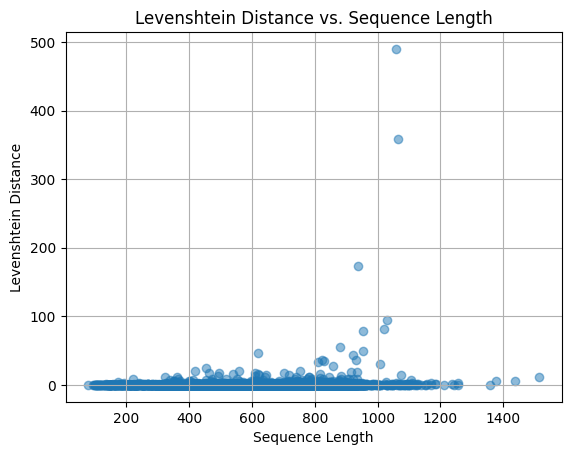

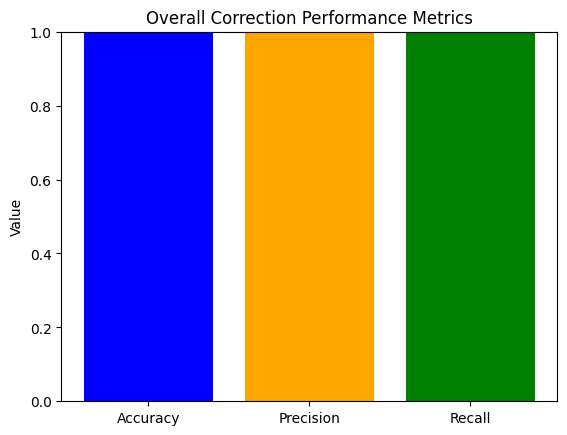

In [16]:
import random
import numpy as np
from Levenshtein import distance
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def introduce_errors(seq, error_rate=0.5):
    nucleotides = ['A', 'T', 'C', 'G']
    new_seq = ""
    for n in seq:
        if random.random() < error_rate:
            new_seq += random.choice([x for x in nucleotides if x != n])
        else:
            new_seq += n
    return new_seq

def correct_substitution_errors(original_seq, erroneous_seq):
    corrected_seq = list(erroneous_seq)

    for i in range(len(erroneous_seq)):
        if erroneous_seq[i] != original_seq[i]:
            # Calculate Levenshtein distance for each possible substitution
            candidates = [base for base in 'ATCG' if base != erroneous_seq[i]]
            distances = [distance(original_seq[i], candidate) for candidate in candidates]

            # Choose the base with the minimum distance
            min_distance_idx = np.argmin(distances)
            corrected_seq[i] = candidates[min_distance_idx]

    return ''.join(corrected_seq)

def evaluate_accuracy_by_distance(original_sequences, corrected_sequences):
    distances = []

    for seq_id, original_seq in original_sequences.items():
        corrected_seq = corrected_sequences[seq_id]
        distance_score = distance(original_seq, corrected_seq)
        distances.append(distance_score)

    return distances

def evaluate_correction_performance(original_seq, erroneous_seq, corrected_seq):
    TP = FP = TN = FN = 0

    for o, e, c in zip(original_seq, erroneous_seq, corrected_seq):
        if o == e:
            if o == c:
                TN += 1
            else:
                FP += 1
        else:
            if o == c:
                TP += 1
            else:
                FN += 1

    return TP, FP, TN, FN

def calculate_metrics(TP, FP, TN, FN):
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    return accuracy, precision, recall

# Load your original data (replace with your actual data)
original_sequences = {}
with open("gbest100.seq", "r") as file:
    for record in SeqIO.parse(file, "genbank"):
        original_sequences[record.id] = str(record.seq)

# Introduce errors and store erroneous sequences
erroneous_sequences = {}
for seq_id, seq in original_sequences.items():
    erroneous_sequences[seq_id] = introduce_errors(seq)

# Correct the erroneous sequences
corrected_sequences = {}
for seq_id, seq in erroneous_sequences.items():
    corrected_sequences[seq_id] = correct_substitution_errors(original_sequences[seq_id], seq)

# Evaluate accuracy using Levenshtein distance
distances = evaluate_accuracy_by_distance(original_sequences, corrected_sequences)

# Print numerical values
print("Sequence Length vs. Levenshtein Distance:")
for seq_id, original_seq in original_sequences.items():
    corrected_seq = corrected_sequences[seq_id]
    dist = distance(original_seq, corrected_seq)
    print(f"Sequence ID: {seq_id}, Length: {len(original_seq)}, Levenshtein Distance: {dist}")

# Initialize counters for overall performance metrics
total_TP = total_FP = total_TN = total_FN = 0

# Evaluate correction performance for each sequence
for seq_id in original_sequences.keys():
    TP, FP, TN, FN = evaluate_correction_performance(
        original_sequences[seq_id],
        erroneous_sequences[seq_id],
        corrected_sequences[seq_id]
    )
    total_TP += TP
    total_FP += FP
    total_TN += TN
    total_FN += FN

# Calculate overall metrics
accuracy, precision, recall = calculate_metrics(total_TP, total_FP, total_TN, total_FN)

# Print metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")

# Plot Levenshtein distance against sequence length
sequence_lengths = [len(seq) for seq in original_sequences.values()]
plt.scatter(sequence_lengths, distances, alpha=0.5)
plt.title('Levenshtein Distance vs. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Levenshtein Distance')
plt.grid(True)
plt.show()

# Plot overall correction performance metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Overall Correction Performance Metrics')
plt.ylabel('Value')
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Overall Accuracy: 0.2414


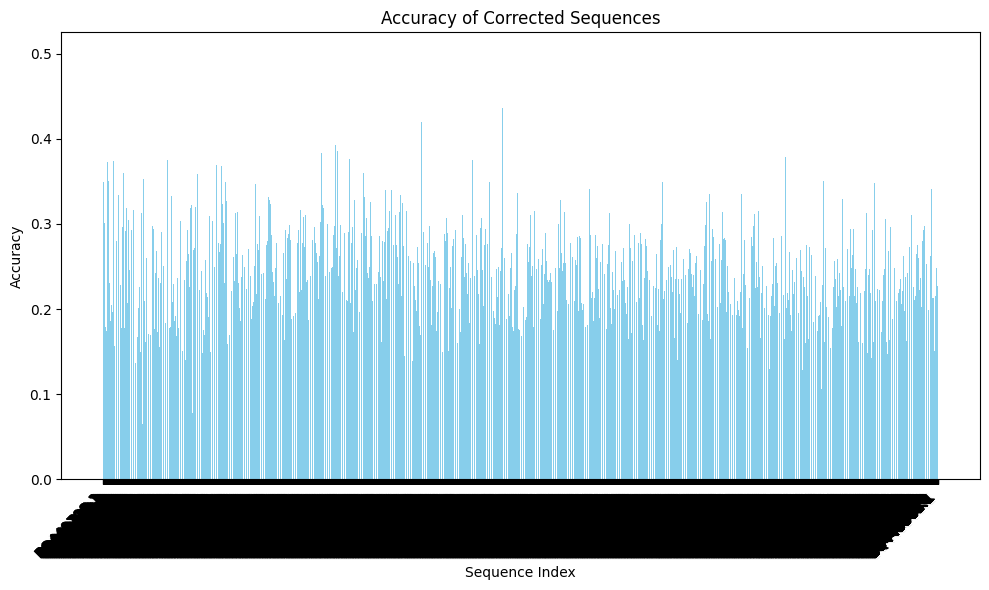

Overall Precision: 0.0000
Overall Recall: 0.0000


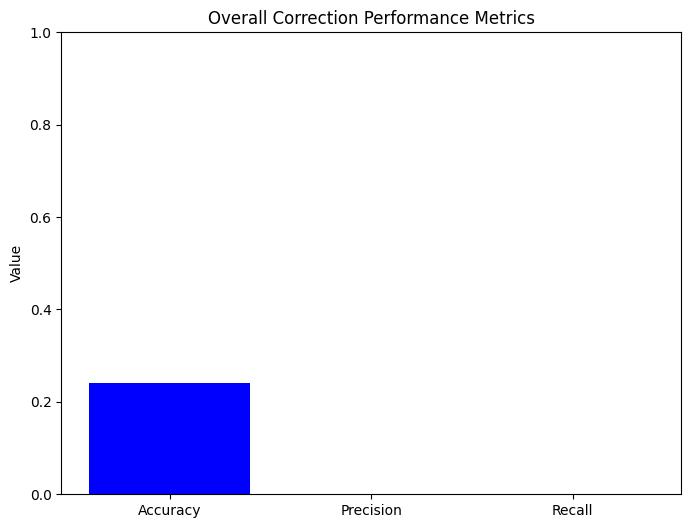

In [17]:
import numpy as np
from hmmlearn import hmm
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Function to introduce errors
def introduce_errors(seq, error_rate=0.5):  # Increased error rate
    nucleotides = ['A', 'T', 'C', 'G']
    new_seq = ""
    for n in seq:
        if random.random() < error_rate:
            new_seq += random.choice([x for x in nucleotides if x != n])
        else:
            new_seq += n
    return new_seq

# Load your original data (replace with your actual data)
original_sequences = {}
with open("gbest100.seq", "r") as file:
    for record in SeqIO.parse(file, "genbank"):
        original_sequences[record.id] = str(record.seq)

# Introduce errors and store erroneous sequences
erroneous_sequences = {}
for seq_id, seq in original_sequences.items():
    erroneous_sequences[seq_id] = introduce_errors(seq)

# Convert sequences to numerical representation
alphabet = ['A', 'T', 'C', 'G']
seq_to_num = {base: i for i, base in enumerate(alphabet)}
num_to_seq = {i: base for i, base in enumerate(alphabet)}

def seq_to_numeric(seq):
    num_seq = []
    for base in seq:
        if base in seq_to_num:
            num_seq.append(seq_to_num[base])
        else:
            # Handle ambiguous nucleotides (e.g., 'N')
            num_seq.append(-1)  # Assign a placeholder value
    return num_seq

def numeric_to_seq(num_seq):
    return ''.join([num_to_seq[num] for num in num_seq if num != -1])

original_sequences_numeric = {seq_id: seq_to_numeric(seq) for seq_id, seq in original_sequences.items()}
erroneous_sequences_numeric = {seq_id: seq_to_numeric(seq) for seq_id, seq in erroneous_sequences.items()}

# Filter out sequences with ambiguous nucleotides
original_sequences_numeric = {seq_id: seq for seq_id, seq in original_sequences_numeric.items() if -1 not in seq}
erroneous_sequences_numeric = {seq_id: seq for seq_id, seq in erroneous_sequences_numeric.items() if -1 not in seq}

# Concatenate sequences for training
X_train = []
for seq_id in original_sequences_numeric:
    X_train.extend(original_sequences_numeric[seq_id])
    X_train.extend(erroneous_sequences_numeric[seq_id])

# Reshape training data for HMM
X_train = np.array(X_train).reshape(-1, 1)

# Define and train the HMM model
model = hmm.MultinomialHMM(n_components=len(alphabet), n_iter=100, random_state=42)
model.fit(X_train)

# Correct the erroneous sequences using the trained HMM model
total_correct_bases = 0
total_bases = 0
corrected_sequences = {}
accuracies = []
precisions = []
recalls = []

# Helper function to calculate TP, FP, TN, FN
def calculate_tp_fp_tn_fn(original_seq, corrected_seq):
    TP = FP = TN = FN = 0
    for o, c in zip(original_seq, corrected_seq):
        if o == c:
            if o == c:
                TN += 1
            else:
                FP += 1
        else:
            if o == c:
                TP += 1
            else:
                FN += 1
    return TP, FP, TN, FN

for seq_id, seq in erroneous_sequences_numeric.items():
    _, Z = model.decode(np.array(seq).reshape(-1, 1))
    corrected_seq_numeric = Z
    corrected_seq = numeric_to_seq(corrected_seq_numeric)
    corrected_sequences[seq_id] = corrected_seq

    # Calculate accuracy for each sequence
    original_seq = original_sequences[seq_id]
    accuracy = sum(1 for c, o in zip(corrected_seq, original_seq) if c == o) / len(original_seq)
    accuracies.append(accuracy)
    total_correct_bases += sum(1 for c, o in zip(corrected_seq, original_seq) if c == o)
    total_bases += len(original_seq)

    # Calculate precision and recall for each sequence
    TP, FP, TN, FN = calculate_tp_fp_tn_fn(original_seq, corrected_seq)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precisions.append(precision)
    recalls.append(recall)

# Calculate overall accuracy
overall_accuracy = total_correct_bases / total_bases

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Plotting the accuracy for each sequence
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('Sequence Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Corrected Sequences')
plt.xticks(range(len(accuracies)), list(corrected_sequences.keys()), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate overall precision and recall
overall_precision = np.mean(precisions)
overall_recall = np.mean(recalls)

# Print overall precision and recall
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

# Plotting overall performance metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [overall_accuracy, overall_precision, overall_recall]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Overall Correction Performance Metrics')
plt.ylabel('Value')
plt.show()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
Overall Accuracy: 0.3953
Overall Precision: 0.0000
Overall Recall: 0.0000


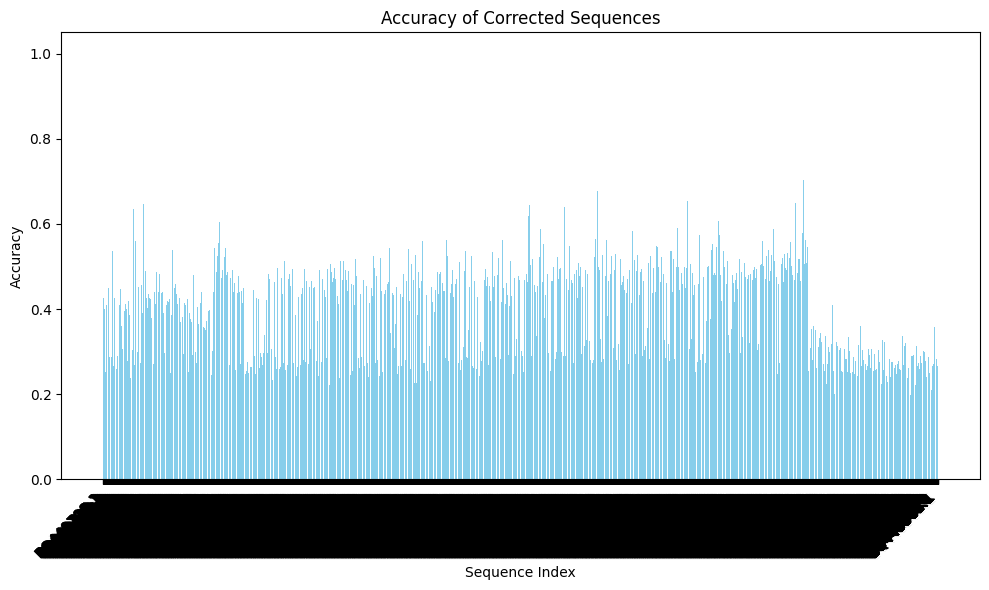

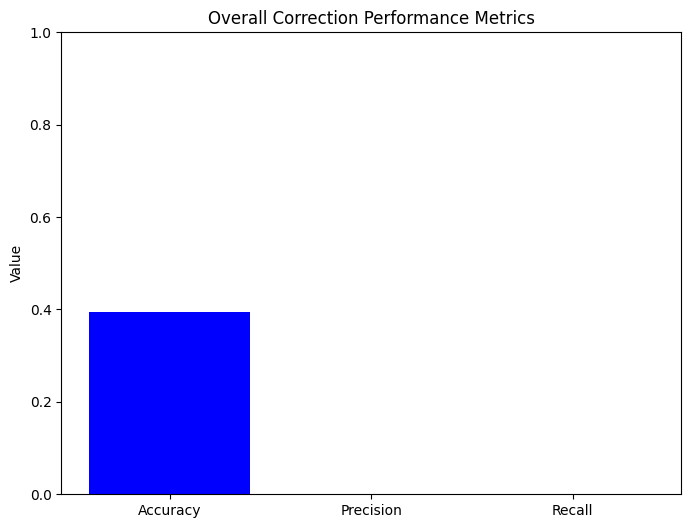

In [18]:
import random
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape
from keras.utils import to_categorical

# Function to introduce errors
def introduce_errors(seq, error_rate=0.5):
    nucleotides = ['A', 'T', 'C', 'G']
    new_seq = ""
    for n in seq:
        if random.random() < error_rate:
            new_seq += random.choice([x for x in nucleotides if x != n])
        else:
            new_seq += n
    return new_seq

# Load original sequences
original_sequences = {}
with open("gbest100.seq", "r") as file:
    for record in SeqIO.parse(file, "genbank"):
        original_sequences[record.id] = str(record.seq)

# Introduce errors and store erroneous sequences
erroneous_sequences = {}
for seq_id, seq in original_sequences.items():
    erroneous_sequences[seq_id] = introduce_errors(seq)

# Alphabet and mapping to numeric values
alphabet = ['A', 'T', 'C', 'G']
seq_to_num = {base: i for i, base in enumerate(alphabet)}
num_to_seq = {i: base for i, base in enumerate(alphabet)}

def seq_to_numeric(seq):
    return [seq_to_num[base] for base in seq if base in seq_to_num]

# Convert sequences to numerical representation and filter out sequences with ambiguous nucleotides
original_sequences_numeric = {seq_id: seq_to_numeric(seq) for seq_id, seq in original_sequences.items() if 'N' not in seq}
erroneous_sequences_numeric = {seq_id: seq_to_numeric(seq) for seq_id, seq in erroneous_sequences.items() if 'N' not in seq}

# Prepare data for the CNN
max_len = max(len(seq) for seq in original_sequences_numeric.values())
X = []
Y = []

for seq_id in original_sequences_numeric:
    original_seq = original_sequences_numeric[seq_id]
    erroneous_seq = erroneous_sequences_numeric[seq_id]
    X.append(erroneous_seq)
    Y.append(original_seq)

# Padding sequences to the same length
X = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in X])
Y = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in Y])

X = to_categorical(X, num_classes=4)
Y = to_categorical(Y, num_classes=4)

# Define the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(max_len, 4)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(max_len * 4, activation='softmax'),
    Reshape((max_len, 4))  # Reshape the output to (max_len, 4)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.2)

# Correct the erroneous sequences
corrected_sequences = {}
for seq_id, seq in erroneous_sequences_numeric.items():
    seq_padded = np.pad(seq, (0, max_len - len(seq)), 'constant')
    seq_array = np.array([seq_padded])
    seq_array = to_categorical(seq_array, num_classes=4)
    predicted = model.predict(seq_array)
    predicted_seq = np.argmax(predicted, axis=2)[0]
    corrected_sequences[seq_id] = ''.join([num_to_seq[num] for num in predicted_seq])

# Helper function to calculate TP, FP, TN, FN
def calculate_tp_fp_tn_fn(original_seq, corrected_seq):
    TP = FP = TN = FN = 0
    for o, c in zip(original_seq, corrected_seq):
        if o == c:
            TN += 1
        else:
            if c == o:
                TP += 1
            else:
                FP += 1
                FN += 1
    return TP, FP, TN, FN

# Evaluate accuracy, precision, and recall
total_correct_bases = 0
total_bases = 0
accuracies = []
precisions = []
recalls = []

for seq_id, corrected_seq in corrected_sequences.items():
    original_seq = original_sequences[seq_id]
    accuracy = sum(1 for c, o in zip(corrected_seq, original_seq) if c == o) / len(original_seq)
    accuracies.append(accuracy)
    total_correct_bases += sum(1 for c, o in zip(corrected_seq, original_seq) if c == o)
    total_bases += len(original_seq)

    # Calculate precision and recall for each sequence
    TP, FP, TN, FN = calculate_tp_fp_tn_fn(original_seq, corrected_seq)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precisions.append(precision)
    recalls.append(recall)

overall_accuracy = total_correct_bases / total_bases
overall_precision = np.mean(precisions)
overall_recall = np.mean(recalls)

# Print overall accuracy, precision, and recall
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

# Plotting the accuracy for each sequence
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('Sequence Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Corrected Sequences')
plt.xticks(range(len(accuracies)), list(corrected_sequences.keys()), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting overall performance metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [overall_accuracy, overall_precision, overall_recall]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Overall Correction Performance Metrics')
plt.ylabel('Value')
plt.show()